In [1]:
cd ..

/home/cody/RepDistiller


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
import copy
import glob
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report

from src.dataloader import make_data_loader
from src.model_loader import load_model
from src.trainers import first_eval, class_report
from src.analytics import fix_state_dict, df_builder

from train_student import load_teacher

/home/cody/miniconda3/envs/RepDist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cody/miniconda3/envs/RepDist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cody/miniconda3/envs/RepDist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cody/miniconda3/envs/RepDist/lib/python3

In [4]:
from dataset.cifar100 import get_cifar100_dataloaders

In [5]:
train_loader, val_loader = get_cifar100_dataloaders(200, 1)
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': 50000, 'val': 10000}

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from models import model_dict

In [7]:
student = model_dict['resnet32x4'](num_classes=100)
teacher = model_dict['resnet32x4'](num_classes=100)

In [8]:
class_names = [['beaver', 'dolphin', 'otter', 'seal', 'whale'],
              ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
              ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
              ['bottle', 'bowl', 'can', 'cup', 'plate'],
              ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
              ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
              ['bed', 'chair', 'couch', 'table', 'wardrobe'],
              ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
              ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
              ['bridge', 'castle', 'house', 'road', 'skyscraper'],
              ['cloud', 'forest', 'mountain', 'plain', 'sea'],
              ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
              ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
              ['crab', 'lobster', 'snail', 'spider', 'worm'],
              ['baby', 'boy', 'girl', 'man', 'woman'],
              ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
              ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
              ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
              ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
              ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']]

class_names = list(np.concatenate(class_names).flat)

In [9]:
teacher_path = './save/models/resnet32x4_vanilla/ckpt_epoch_240.pth'
teacher = load_teacher(teacher_path, 100)

==> loading teacher model
==> done


## Setup 

create student and teacher models. Load them onto device.
gather teacher predictions over validation set.

In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


student = student.to(device)
teacher = teacher.to(device)

ground_labels, teacher_pred = class_report(teacher, dataloaders, dataset_sizes)
_, student_pred = class_report(student, dataloaders, dataset_sizes)


report = classification_report(ground_labels, teacher_pred, target_names=class_names, output_dict=True)


In [11]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


student = student.to(device)
teacher = teacher.to(device)

ground_labels, teacher_pred = class_report(teacher, dataloaders, dataset_sizes)
_, student_pred = class_report(student, dataloaders, dataset_sizes)


report = classification_report(ground_labels, teacher_pred, target_names=class_names, output_dict=True)


In [12]:
teacher_pred

array([68., 33., 72., ..., 51., 42., 70.])

In [13]:
from sklearn.metrics import confusion_matrix

Make PIE and classification report DF builder

In [14]:
dfs = df_builder(ground_labels, teacher_pred)

In [15]:
glob.glob('save/student_model/*similarity*a:0*ts:0.4*[!bias]/*best.pth')

['save/student_model/S:resnet32x4_T:resnet32x4_cifar100_similarity_r:1_a:0.0_b:3000.0_1_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth',
 'save/student_model/S:resnet32x4_T:resnet32x4_cifar100_similarity_r:1_a:0.0_b:3000.0_3_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth',
 'save/student_model/S:resnet32x4_T:resnet32x4_cifar100_similarity_r:1_a:0.0_b:3000.0_0_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth',
 'save/student_model/S:resnet32x4_T:resnet32x4_cifar100_similarity_r:1_a:0.0_b:3000.0_2_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth']

In [16]:
glob.glob('save/student_model/*crd*ts:0.4*lr:0.05*/*best.pth')

['save/student_model/S:resnet32x4_T:resnet32x4_cifar100_crd_r:1_a:0.0_b:0.8_1_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth',
 'save/student_model/S:resnet32x4_T:resnet32x4_cifar100_crd_r:1_a:0.0_b:0.8_2_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth',
 'save/student_model/S:resnet32x4_T:resnet32x4_cifar100_crd_r:1_a:0.0_b:0.8_3_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth',
 'save/student_model/S:resnet32x4_T:resnet32x4_cifar100_crd_r:1_a:0.0_b:0.8_0_ts:0.45_strat:struct_lr:0.05/resnet8x4_best.pth']

run model statistics over population for PIE and accuracy and ad them to data frame 

In [17]:
mag_30 = glob.glob('save/student_model/*lr_0.05*ts:0.3*/*best.pth') 
mag_45 = glob.glob('save/student_model/*lr_0.05*ts:0.4*/*best.pth') 
mag_60 = glob.glob('save/student_model/*lr_0.05*ts:0.6*/*best.pth') 
mag_75 = glob.glob('save/student_model/*lr_0.05*ts:0.7*/*best.pth') 
mag_90 = glob.glob('save/student_model/*lr_0.05*ts:0.9*/*best.pth') 

models = [(mag_30, 30), (mag_45, 45), (mag_60, 60), (mag_75, 75), (mag_90, 90)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='Struct Pruning', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [18]:
sim_30 = glob.glob('save/student_model/*similarity*a:0*ts:0.3*/*best.pth') 
sim_45 = glob.glob('save/student_model/*similarity*a:0*ts:0.4*/*best.pth')
sim_60 = glob.glob('save/student_model/*similarity*a:0*ts:0.6*/*best.pth')
sim_75 = glob.glob('save/student_model/*similarity*a:0*ts:0.7*/*best.pth') 
sim_90 = glob.glob('save/student_model/*similarity*a:0*ts:0.9*/*best.pth')

models = [(sim_30, 30), (sim_45, 45), (sim_60, 60), (sim_75, 75), (sim_90, 90)]

for (paths, sparsity) in models:

    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='SP', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [19]:
kd_30 = glob.glob('save/student_model/*resnet32x4*kd*ts:0.3*lr:0.05*/*best.pth') 
kd_45 = glob.glob('save/student_model/*resnet32x4*kd*ts:0.4*lr:0.05*/*best.pth') 
kd_60 = glob.glob('save/student_model/*resnet32x4*kd*ts:0.6*lr:0.05*/*best.pth') 
kd_75 = glob.glob('save/student_model/*resnet32x4*kd*ts:0.7*lr:0.05*/*best.pth') 
kd_90 = glob.glob('save/student_model/*resnet32x4*kd*ts:0.9*lr:0.05*/*best.pth') 

models = [(kd_30, 30), (kd_45, 45), (kd_60, 60), (kd_75, 75), (kd_90, 90)]

for (paths, sparsity) in models:
    
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='KD', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [20]:

at_45 = glob.glob('save/student_model/*resnet32x4*attention*a:0*ts:0.4*lr:0.005*/*best.pth')
at_30 = glob.glob('save/student_model/*resnet32x4*attention*ts:0.3*lr:0.005/*best.pth')
at_60 = glob.glob('save/student_model/*resnet32x4*attention*ts:0.6*lr:0.005/*best.pth')
at_75 = glob.glob('save/student_model/*resnet32x4*attention*ts:0.7*lr:0.005/*best.pth')
at_90 = glob.glob('save/student_model/*resnet32x4*attention*ts:0.9*lr:0.005/*best.pth')

models = [(at_30, 30), (at_45, 45), (at_60, 60), (at_75, 75), (at_90, 90)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='AT', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [21]:
pkt_45 = glob.glob('save/student_model/*resnet32x4*pkt*a:0*ts:0.4*lr:0.005/*best.pth')
pkt_30 = glob.glob('save/student_model/*resnet32x4*pkt*a:0*ts:0.3*lr:0.005/*best.pth')
pkt_60 = glob.glob('save/student_model/*resnet32x4*pkt*a:0*ts:0.6*lr:0.005/*best.pth')
pkt_75 = glob.glob('save/student_model/*resnet32x4*pkt*a:0*ts:0.7*lr:0.005/*best.pth')
pkt_90 = glob.glob('save/student_model/*resnet32x4*pkt*a:0*ts:0.9*lr:0.005/*best.pth')

models = [(pkt_30, 30), (pkt_45, 45), (pkt_60, 60), (pkt_75, 75), (pkt_90, 90)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='PKT', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [22]:
crd_45 = glob.glob('save/student_model/*crd*ts:0.4*lr:0.05/*best.pth')
crd_30 = glob.glob('save/student_model/*crd*ts:0.3*lr:0.05/*best.pth')
crd_60 = glob.glob('save/student_model/*crd*ts:0.6*lr:0.05/*best.pth')
crd_75 = glob.glob('save/student_model/*crd*ts:0.7*lr:0.05/*best.pth')
crd_90 = glob.glob('save/student_model/*crd*ts:0.9*lr:0.05/*best.pth')

models = [(crd_30, 30), (crd_45, 45), (crd_60, 60), (crd_75, 75), (crd_90, 90)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='CRD', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [23]:
all_45 = glob.glob('save/student_model/*resnet32x4*all*a:0*ts:0.4*lr:0.05/*best.pth')
all_30 = glob.glob('save/student_model/S:resnet32x4_T:resnet32x4_cifar100_all_r:1.0_a:0.0_b:1*ts:0.3*lr:0.05/*best.pth')
all_60 = glob.glob('save/student_model/*resnet32x4*all*a:0*ts:0.6*lr:0.05/*best.pth')
all_75 = glob.glob('save/student_model/*resnet32x4*all*a:0*ts:0.7*lr:0.05/*best.pth')
all_90 = glob.glob('save/student_model/*resnet32x4*all*a:0*ts:0.9*lr:0.05/*best.pth')

models = [(all_30, 30), (all_45, 45), (all_60, 60), (all_75, 75), (all_90, 90)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='FSP', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:
/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
sims = {'Struct Pruning': [np.array([0.11076383, 0.23093504, 0.55483049, 0.20734002]),
  np.array([0.12564581, 0.26617607, 0.57405552, 0.23733528]),
  np.array([0.16858421, 0.31926581, 0.60245958, 0.273138  ]),
  np.array([0.22644553, 0.39126544, 0.63017884, 0.28000446]),
  np.array([0.23203238, 0.42617299, 0.62021048, 0.31071572])],
 'SP': [np.array([0.07492287, 0.16262624, 0.44531006, 0.1222202 ]),
  np.array([0.11477873, 0.2398724 , 0.53158841, 0.16901009]),
  np.array([0.16076702, 0.30538747, 0.58111922, 0.21462908]),
  np.array([0.22093787, 0.38569866, 0.62026973, 0.22960122]),
  np.array([0.22687929, 0.4183962 , 0.61449039, 0.34005357])],
 'KD': [np.array([0.0793261 , 0.17867119, 0.48005776, 0.1256899 ]),
  np.array([0.10877489, 0.23096418, 0.53844362, 0.15449415]),
  np.array([0.15264054, 0.30507977, 0.58796684, 0.19709052]),
  np.array([0.22057854, 0.39440924, 0.62250158, 0.22471598]),
  np.array([0.24369474, 0.43213832, 0.59883173, 0.42920731])],
 'AT': [np.array([0.01790905, 0.04661237, 0.36544695, 0.09287789]),
  np.array([0.04311327, 0.10371352, 0.4713463 , 0.13407147]),
  np.array([0.09263731, 0.20403342, 0.55356818, 0.18684003]),
  np.array([0.17966395, 0.32577137, 0.60164744, 0.25033623]),
  np.array([0.22131847, 0.39305268, 0.60129328, 0.32312638])],
 'PKT': [np.array([0.03316436, 0.08714193, 0.41869634, 0.10676396]),
  np.array([0.08017559, 0.18166487, 0.51047111, 0.15465331]),
  np.array([0.13295741, 0.27276982, 0.56646092, 0.19110268]),
  np.array([0.2103369 , 0.36743296, 0.61066787, 0.24307072]),
  np.array([0.27500987, 0.43450452, 0.61007744, 0.36328089])],

 'CRD': [np.array([0.11423176, 0.24394627, 0.53166722, 0.16832384]),
 np.array([0.13933901, 0.27980629, 0.56730361, 0.19708504]),
 np.array([0.18144852, 0.33656165, 0.6038239 , 0.22038917]),
 np.array([0.23477177, 0.40419688, 0.63123876, 0.26381856]),
 np.array([0.21553959, 0.41270655, 0.60422202, 0.4201684 ])],

'FSP':[np.array([0.02112578, 0.08427027, 0.38707027, 0.11473299]),
 np.array([0.04520613, 0.16413589, 0.50431585, 0.16410742]),
 np.array([0.08614644, 0.23635338, 0.56550932, 0.21078132]),
 np.array([0.1624126 , 0.34490173, 0.61096752, 0.27234997]),
 np.array([0.22337134, 0.4177568 , 0.59568648, 0.36828532])]
 }


In [26]:
val_stack = np.stack([val for key, val in sims.items()])

In [27]:
## this is not a true copy should have used deep copy
## everything worked out though
df_copy = dfs.PIEs
features = ['block1', 'block2', 'block3', 'fc']
for i, feature in enumerate(features):
    print(feature)
    print(val_stack[:,:,i].flatten())
    df_copy[feature] = val_stack[:,:,i].flatten()

df_copy

block1
[0.11076383 0.12564581 0.16858421 0.22644553 0.23203238 0.07492287
 0.11477873 0.16076702 0.22093787 0.22687929 0.0793261  0.10877489
 0.15264054 0.22057854 0.24369474 0.01790905 0.04311327 0.09263731
 0.17966395 0.22131847 0.03316436 0.08017559 0.13295741 0.2103369
 0.27500987 0.11423176 0.13933901 0.18144852 0.23477177 0.21553959
 0.02112578 0.04520613 0.08614644 0.1624126  0.22337134]
block2
[0.23093504 0.26617607 0.31926581 0.39126544 0.42617299 0.16262624
 0.2398724  0.30538747 0.38569866 0.4183962  0.17867119 0.23096418
 0.30507977 0.39440924 0.43213832 0.04661237 0.10371352 0.20403342
 0.32577137 0.39305268 0.08714193 0.18166487 0.27276982 0.36743296
 0.43450452 0.24394627 0.27980629 0.33656165 0.40419688 0.41270655
 0.08427027 0.16413589 0.23635338 0.34490173 0.4177568 ]
block3
[0.55483049 0.57405552 0.60245958 0.63017884 0.62021048 0.44531006
 0.53158841 0.58111922 0.62026973 0.61449039 0.48005776 0.53844362
 0.58796684 0.62250158 0.59883173 0.36544695 0.4713463  0.5535

,PIEs,method,sparsity,block1,block2,block3,fc
0,674.0,Struct Pruning,30.0,0.110764,0.230935,0.554830,0.207340
1,711.0,Struct Pruning,45.0,0.125646,0.266176,0.574056,0.237335
2,741.0,Struct Pruning,60.0,0.168584,0.319266,0.602460,0.273138
3,887.0,Struct Pruning,75.0,0.226446,0.391265,0.630179,0.280004
4,1407.0,Struct Pruning,90.0,0.232032,0.426173,0.620210,0.310716
5,353.0,SP,30.0,0.074923,0.162626,0.445310,0.122220
6,654.0,SP,45.0,0.114779,0.239872,0.531588,0.169010
7,737.0,SP,60.0,0.160767,0.305387,0.581119,0.214629
8,860.0,SP,75.0,0.220938,0.385699,0.620270,0.229601
9,1380.0,SP,90.0,0.226879,0.418396,0.614490,0.340054


In [28]:
pkt_45 = glob.glob('save/student_model/*resnet32x4*pkt*a:1*ts:0.4*lr:0.005*/*best.pth')


models = [(pkt_45, 45)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='PKT + KD', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [29]:

sim_45 = glob.glob('save/student_model/*similarity*a:1*ts:0.4*/*best.pth')


models = [(sim_45, 45)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='SP + KD', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [30]:
all_45 = glob.glob('save/student_model/*resnet32x4*all*a:1*ts:0.4*lr:0.05*/*best.pth')


models = [(all_45, 45)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='FSP + KD', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [31]:
at_45 = glob.glob('save/student_model/*resnet32x4*attention*a:1*ts:0.4*lr:0.005*/*best.pth')


models = [(at_45, 45)]

for (paths, sparsity) in models:
    paths = [path for path in paths if 'bias' not in path]
    dfs.add_models(paths=paths, sparsity=sparsity, method='AT + KD', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/RepDistiller/src/analytics.py:101: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [33]:
import pickle

In [34]:
with open("dfs.pickle", 'wb') as f:
    pickle.dump(dfs, f)

In [35]:
methods = []
for method in dfs.PIEs['method']:
    if method not in methods:
        methods.append(method)

In [36]:
methods

['Struct Pruning',
 'Similarity Preserving Struct',
 'KD Struct',
 'Attention Struct',
 'PKT Struct Mag',
 'CRD Struct Mag']

In [37]:
teacher_conf = confusion_matrix(ground_labels, teacher_pred)

In [38]:
%config InlineBackend.figure_format = 'retina'

In [39]:
sns.set_palette(sns.color_palette("colorblind"))

In [40]:
line_styles = ['-', '--', '-.', ':', 'dashed', 'dashdot', 'dotted']

In [41]:
colors = sns.color_palette()

In [42]:
method_colors = {method: color for method, color in zip(methods, colors)}

In [43]:
markers = ['o', 'v', '^', '<', '>', 's', 'p', 'P', 'h', 'X']
method_markers = {method: marker for method, marker in zip(methods, markers)}

In [44]:
method_markers

{'Struct Pruning': 'o',
 'Similarity Preserving Struct': 'v',
 'KD Struct': '^',
 'Attention Struct': '<',
 'PKT Struct Mag': '>',
 'CRD Struct Mag': 's'}

NameError: name 'plt' is not defined

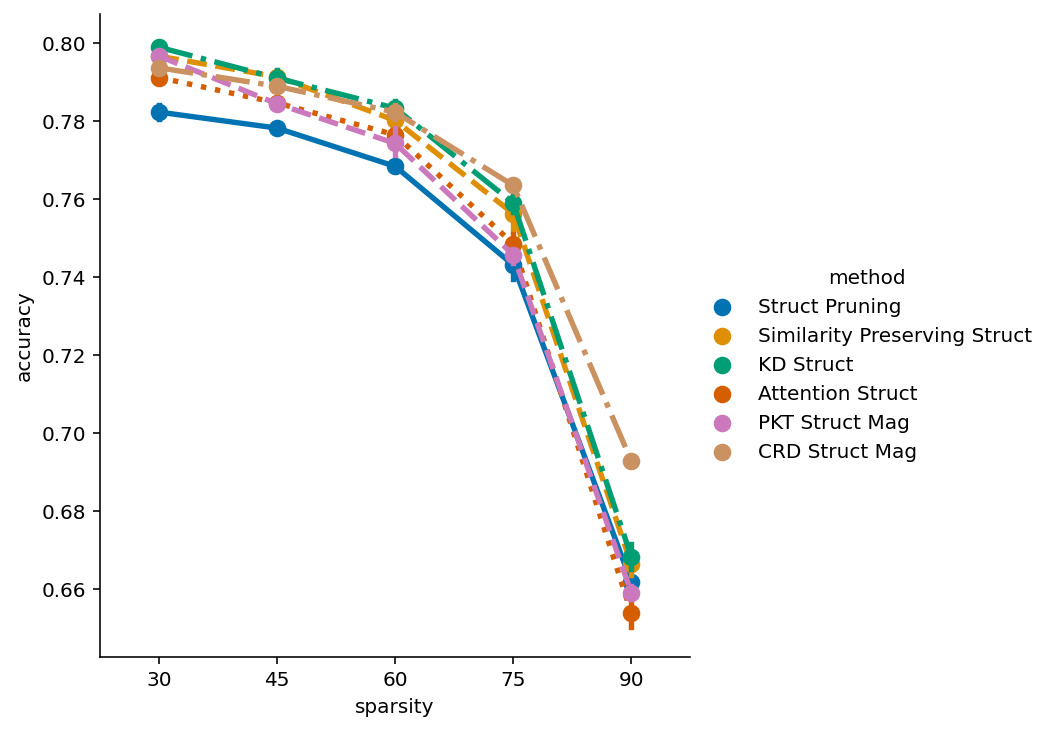

In [45]:
acc_plot = sns.catplot(x='sparsity', y='accuracy', hue='method', kind='point', 
                       data=dfs.pruning_stats, linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
                       scatter_kws={'s':1})
plt.title('Knowledge Distillation Accuracy Curve')
acc_plot.savefig('figures/Acc_Struct.jpg', dpi=600)
acc_plot.savefig('figures/Acc_Struct.png', dpi=600)

In [ ]:
method_colors

In [ ]:
sparsity=90

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

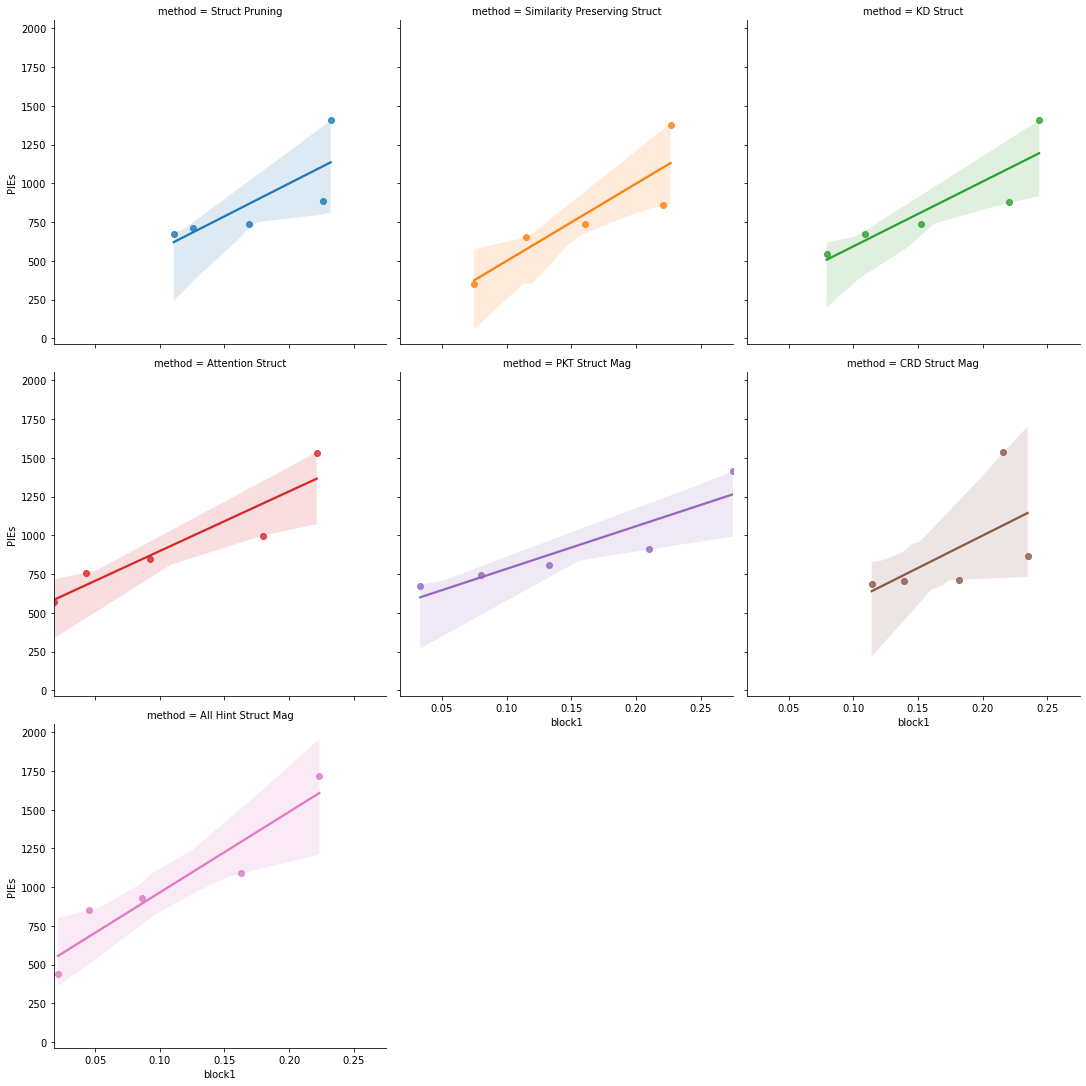

In [36]:

p = sns.lmplot(x='block1', y='PIEs', hue='method', col='method', col_wrap=3, data=df_copy)


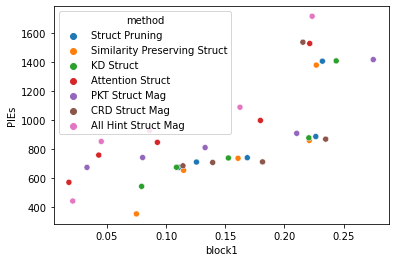

In [37]:

p = sns.scatterplot(x='block1', y='PIEs', hue='method', data=df_copy)


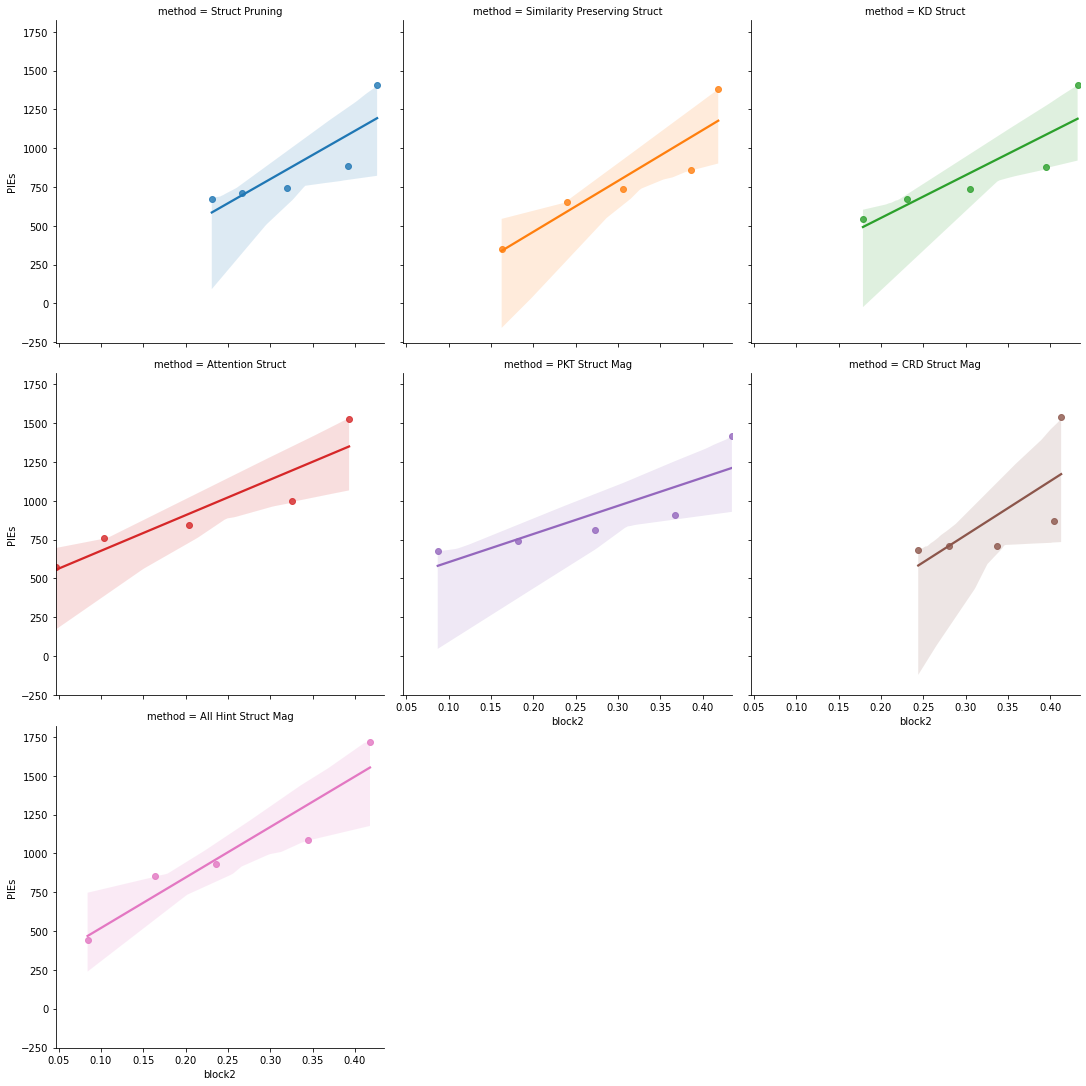

In [38]:
sns.lmplot(x='block2', y='PIEs', hue='method', col='method',  col_wrap=3, data=df_copy)

<AxesSubplot:xlabel='block2', ylabel='PIEs'>

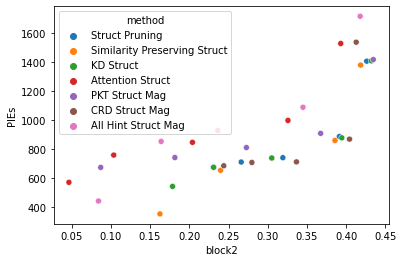

In [39]:
sns.scatterplot(x='block2', y='PIEs', hue='method', data=df_copy)

In [916]:
sorted(zip(class_names, FPR_PRUNE_change), key=lambda x:x[1], reverse=True)[:10]

[('dinosaur', 1283806.25),
 ('dolphin', 841400.0),
 ('mushroom', 694274.9999999999),
 ('pine_tree', 618650.0),
 ('shark', 544400.0),
 ('cattle', 439900.0000000001),
 ('rabbit', 378025.00000000006),
 ('tulip', 311750.00000000006),
 ('leopard', 308012.2448979592),
 ('bus', 302400.0)]

In [917]:
sorted(zip(class_names, FPR_AT_change), key=lambda x:x[1], reverse=True)[:10]

[('dinosaur', 1113650.0),
 ('dolphin', 950300.0000000002),
 ('pine_tree', 666775.0),
 ('mushroom', 584275.0000000001),
 ('shark', 584000.0000000001),
 ('tulip', 437975.0),
 ('leopard', 353471.4285714286),
 ('bus', 345177.7777777778),
 ('rabbit', 329900.0),
 ('cattle', 316150.00000000006)]

In [918]:
sorted(zip(class_names, FPR_PKT_change), key=lambda x:x[1], reverse=True)[:10]

[('dinosaur', 958962.5),
 ('shark', 772100.0000000001),
 ('dolphin', 772099.9999999999),
 ('pine_tree', 756149.9999999999),
 ('mushroom', 687400.0),
 ('leopard', 459542.85714285716),
 ('cattle', 412400.0),
 ('rabbit', 384900.00000000006),
 ('bus', 336011.11111111107),
 ('tulip', 301849.99999999994)]

In [919]:
sorted(zip(class_names, FPR_SIM_change), key=lambda x:x[1], reverse=True)[:10]

[('dinosaur', 1345681.25),
 ('dolphin', 712700.0000000001),
 ('shark', 633500.0000000001),
 ('mushroom', 591150.0),
 ('pine_tree', 536150.0),
 ('leopard', 383777.55102040817),
 ('tulip', 371150.0),
 ('cattle', 323025.00000000006),
 ('rabbit', 302399.99999999994),
 ('chimpanzee', 288309.0909090909)]

In [920]:
sorted(zip(class_names, FPR_KD_change), key=lambda x:x[1], reverse=True)[:10]

[('dinosaur', 1206462.5),
 ('dolphin', 732500.0000000001),
 ('mushroom', 708025.0),
 ('pine_tree', 481150.0000000001),
 ('shark', 455300.0),
 ('tulip', 386000.00000000006),
 ('leopard', 333267.34693877544),
 ('cattle', 323025.00000000006),
 ('rose', 285212.50000000006),
 ('spider', 247400.0)]

In [921]:
sorted(zip(class_names, FNR_PRUNE_change), key=lambda x:x[1], reverse=True)[:10]

[('plain', 10733.333333333334),
 ('road', 8233.333333333334),
 ('shark', 6705.5555555555575),
 ('beaver', 4761.111111111111),
 ('willow_tree', 4236.734693877551),
 ('spider', 4200.0),
 ('trout', 4185.714285714285),
 ('crocodile', 2634.375),
 ('elephant', 2554.320987654321),
 ('skyscraper', 2400.0000000000005)]

In [922]:
sorted(zip(class_names, FNR_AT_change), key=lambda x:x[1], reverse=True)[:10]

[('plain', 17122.222222222223),
 ('road', 9066.666666666668),
 ('shark', 4344.444444444445),
 ('beaver', 4344.444444444444),
 ('trout', 4185.714285714285),
 ('spider', 3799.999999999999),
 ('willow_tree', 3777.551020408163),
 ('crocodile', 2673.4375),
 ('can', 2616.04938271605),
 ('cattle', 2556.25)]

In [923]:
sorted(zip(class_names, FNR_PKT_change), key=lambda x:x[1], reverse=True)[:10]

[('plain', 14066.666666666666),
 ('road', 11844.444444444445),
 ('shark', 4830.555555555556),
 ('trout', 4542.857142857142),
 ('spider', 4500.0),
 ('beaver', 4066.666666666667),
 ('willow_tree', 3879.5918367346935),
 ('leopard', 2523.456790123457),
 ('crocodile', 2517.1875),
 ('can', 2338.271604938272)]

In [924]:
sorted(zip(class_names, FNR_SIM_change), key=lambda x:x[1], reverse=True)[:10]

[('plain', 12122.222222222223),
 ('road', 9344.444444444445),
 ('shark', 4969.444444444444),
 ('trout', 4134.693877551021),
 ('beaver', 4066.6666666666665),
 ('spider', 3999.999999999999),
 ('willow_tree', 3624.4897959183672),
 ('crocodile', 2595.3125),
 ('elephant', 2523.456790123457),
 ('skyscraper', 2430.864197530864)]

In [925]:
sorted(zip(class_names, FNR_KD_change), key=lambda x:x[1], reverse=True)[:10]

[('plain', 13511.111111111111),
 ('road', 11011.111111111113),
 ('shark', 6080.555555555556),
 ('trout', 4440.816326530612),
 ('willow_tree', 3522.4489795918366),
 ('beaver', 3163.888888888889),
 ('spider', 3000.0),
 ('elephant', 2770.3703703703704),
 ('apple', 2595.3125),
 ('crocodile', 2439.0625)]

In [663]:
class_names, ik = dfs.pie_idx['Struct Pruning'][75], dfs.pie_idx['PKT Struct Mag'][75]

KeyError: 75

In [ ]:
ik_not_sm = np.nonzero(np.isin(ik, sm, invert=True))[0]
sm_not_ik = np.nonzero(np.isin(sm, ik, invert=True))[0]
inter = np.intersect1d(ik, sm)
print(f'finegrain PIES: {sm.size}')
print(f'ik PIES: {ik.size}')
print(f'# in fg not in ik: {sm_not_ik.size}')
print(f'# in ik not in fg: {ik_not_sm.size}')
print(f'intersection : {inter.size}')


In [14]:
inter_ds = make_data_loader(1, dataset='cifar10', subset=inter)
ik_ds = make_data_loader(1, dataset='cifar10', subset=ik)
sm_ds = make_data_loader(1, dataset='cifar10', subset=sm)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
ground_labels_inter, teacher_pred_inter = class_report(teacher, inter_ds[0], inter_ds[1])
report_inter = classification_report(ground_labels_inter, 
                                     teacher_pred_inter, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_ik, teacher_pred_ik = class_report(teacher, ik_ds[0], ik_ds[1])
report_ik = classification_report(ground_labels_ik, 
                                     teacher_pred_ik, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_sm, teacher_pred_sm = class_report(teacher, sm_ds[0], sm_ds[1])
report_sm = classification_report(ground_labels_sm, 
                                     teacher_pred_sm, 
                                     target_names=class_names, 
                                     output_dict=True)

In [16]:
print(f'intersection accuracy {report_inter["accuracy"]}')
print(f'IK PIES accuracy {report_ik["accuracy"]}')
print(f'SM PIES accuracy {report_sm["accuracy"]}')

intersection accuracy 0.4
IK PIES accuracy 0.5128205128205128
SM PIES accuracy 0.4986301369863014


In [23]:
pruning_stats = dfs.pruning_stats

In [32]:
struct_reports = list(pruning_stats.query('method == "struct_mag" & sparsity == 75')['full_report'])

In [33]:
ik_reports = list(pruning_stats.query('method == "ik_struct_mag" & sparsity == 75')['full_report'])

In [34]:
from scipy import stats

In [40]:
for name in class_names:
    _, p = stats.ttest_ind([x[name]['precision'] for x in struct_reports], [x[name]['precision'] for x in ik_reports])
    if p < .05:
        print(name)

automobile
horse
ship
truck


In [41]:
for name in class_names:
    _, p = stats.ttest_ind([x[name]['recall'] for x in struct_reports], [x[name]['recall'] for x in ik_reports])
    if p < .05:
        print(name)

airplane
automobile
deer
dog
horse
truck


In [21]:
image, label = next(iter(inter_ds[0]['val']))

In [22]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torch.nn import Upsample


In [23]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

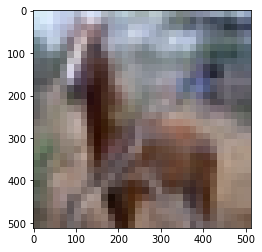

In [24]:
up = Upsample(scale_factor=16, mode='nearest')
for i, (image, label) in enumerate(inter_ds[0]['val']):
    image = up(image)
    show(make_grid(image, nrow=8, normalize=True))
    path = 'figures/PIE_images/'
    name = f'pie_{i}_{class_names[label]}_{class_names[int(teacher_pred_inter[i])]}.jpg'
    save_image(image, normalize=True, fp=path+name)

In [25]:
teacher_pred_inter[0]

4.0

In [ ]:
p